# Multi-class Dog Breed Classification
Multiclass Dog Breed classification model build with TensorFlow and TensorFlow Hub

## 1. Problem
Given an image of a dog, asked to identify its breed.

## 2. Data
Data used is taken from Stanford University Dogs Dataset http://vision.stanford.edu/aditya86/ImageNetDogs/

## 3. Evaluation
The resultant model will be evaluated based on the Multi-class Log Loss.

## 4. Features
- Unstructured data (images)
- 120 Categories (dog breeds)
- Total of 20579 unique images.
- Approximately 150 images per breed.

## Note: 
- The data has been downloaded and extracted beforehand, hence why the procedure is not shown in the notebook. 
- ^^ Personally retrieved the data with `!wget` and then extracted it with the `tarfile` library.
- It can be noted that one of the image in the dataset may be corrupted during extraction (as seen from the use of 20579 instead of 20580), 
so errors when processing/fitting the whole data might be occur.
- A simple solution that was done was the use a `Binary Search` strategy to find the corrupted image and remove it from the data.

# First, We Need to Prepare Libraries

In [ ]:
pip install colabcode

In [ ]:
pip install tensorflow_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 KB 11.8 MB/s eta 0:00:00
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Import libraries
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import os
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

#Check whether theres GPU available
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.7.0
TF Hub version: 0.12.0
GPU available


2022-06-26 09:41:59.415592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 09:41:59.494382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 09:41:59.495003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Second, We need to prepare the datasets
## First we get the filenames and labels

In [ ]:
labels = []
filenames = []

for folders in os.listdir("train_images/Images"):
    breed = "".join(folders.split("-")[1:])
    for fname in os.listdir(f"train_images/Images/{folders}"):
        if fname[-3:] == "jpg":
            labels.append(breed)
            filenames.append(f"train_images/Images/{folders}/{fname}")
        else:
            print(fname)

# convert to np array for convinience
labels = np.array(labels)
filenames = np.array(filenames)
len(labels), len(filenames), labels[0], filenames[0]

.ipynb_checkpoints


(20579,
 20579,
 'Chesapeake_Bay_retriever',
 'train_images/Images/n02099849-Chesapeake_Bay_retriever/n02099849_68.jpg')

## Then we get the unique labels

In [ ]:
unique_breeds = np.unique(labels)
len(unique_breeds), unique_breeds[:10]

(120,
 array(['Afghan_hound', 'African_hunting_dog', 'Airedale',
        'American_Staffordshire_terrier', 'Appenzeller',
        'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog',
        'Blenheim_spaniel', 'Border_collie'], dtype='<U30'))

## Finally we convert the labels into an array of boolean values 0 and 1

In [ ]:
boolean_labels = np.array([label == unique_breeds for label in labels])
boolean_labels.shape

(20579, 120)

In [ ]:
print(labels[0]) # label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occur in boolean array
print(boolean_labels[0].astype(int)) #convert bool to int

Chesapeake_Bay_retriever
(array([16]),)
16
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## With that our x and y data are ready

In [ ]:
x = filenames
y = boolean_labels
x[:5], y[:5]

(array(['train_images/Images/n02099849-Chesapeake_Bay_retriever/n02099849_68.jpg',
        'train_images/Images/n02099849-Chesapeake_Bay_retriever/n02099849_3315.jpg',
        'train_images/Images/n02099849-Chesapeake_Bay_retriever/n02099849_2250.jpg',
        'train_images/Images/n02099849-Chesapeake_Bay_retriever/n02099849_130.jpg',
        'train_images/Images/n02099849-Chesapeake_Bay_retriever/n02099849_3369.jpg'],
       dtype='<U80'),
 array([[False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False,  True, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, 

## Next step is to prepare our image data into a format which can be processed and trained by TensorFlow aka tensors

In [ ]:
#Define image size
IMG_SIZE = 224

#Function for preprocessing
def process_image(filename, img_size=IMG_SIZE):
  """
  Takes an image filepath and turns it into a tensor.
  """
  #read image
  image = tf.io.read_file(filename)

  #turn jpeg to numerical Tensor with 3 color channels (RGB)
  image = tf.image.decode_jpeg(image, channels=3)

  #Convert colour channels values 0-255 to 0-1 values.
  #This is a normalization process to make process more efficient.
  image = tf.image.convert_image_dtype(image, tf.float32)

  #Resize to (224,224)
  image = tf.image.resize(image, size=[img_size, img_size])

  return image

#Create a function to return a tuple of (image, label)
def get_image_tuple(filename, label):
  """
  Takes an image file path and label
  then processes and return a tuple (image, label)
  """
  image = process_image(filename)
  return image, label

In [ ]:
process_image(x[0]).shape # Creates a tensor with shape 224,224, 3 for the 3 layers of color RGB

TensorShape([224, 224, 3])

## Function to convert image into processed tensors batch datasets 

In [ ]:
BATCH_SIZE = 32

#function to turn data to batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Create batches of data out of (image x) and (label y) pairs.
  Shuffles the data if its training data, but not when validation data.
  Also accepts test data as input (no labels).
  """
  #If test dataset, we probably don't have labels
  if test_data:
    print(f"Creating test data batches... BATCH SIZE={batch_size}")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(x))
    data_batch = data.map(process_image).batch(batch_size)

  #If validation dataset, we don't need to shuffle
  elif valid_data:
    print(f"Creating validation data batches... BATCH SIZE={batch_size}")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), #filepath
                                              tf.constant(y))) # labels
    data_batch = data.map(get_image_tuple).batch(batch_size)
  
  else:
    print(f"Creating training data batches... BATCH SIZE={batch_size}")
    #turn filepath and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), #filepath
                                              tf.constant(y))) # labels
    #shuffle
    data = data.shuffle(buffer_size=len(x))

    #process into (image,label) tuple and make batch
    data = data.map(get_image_tuple)
    data_batch = data.batch(batch_size)
  return data_batch

# Building a Model !

Before we build a model, there are a few things we need to define:
* The input shape (image shape in the form of Tensors)
* The output shape (image labels in the form of Tensors)
* URL of model we want to use Transfer Learning with from TensorFlow Hub
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

^^ MobileNet Image Classification (Size = 224x224, Depth Multiplier = 1.3)

In [ ]:
#setup input shape into the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] #batch, height, width, colour channel

#setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

#setup model URL from Tensorflow HUB
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now we've got our Inputs, Outputs, and Model ready...
Lets put them together into a Keras Deep Learning Model!

Knowing this, let's create a function that:
* takes input shape, output shape, and model as parameters
* Defines the layers of KEras Model in a sequential fashion
* Compiles the model (Says it should be evaluated and improved)
* Builds model (Tell model the input shape it'll be getting)
* Return the model

All the steps can be found in https://www.tensorflow.org/guide/keras/overview

In [ ]:
# Create a Function which builds a Keras Model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print(f"Building model with {MODEL_URL}")

  # Setup Model Layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (Input Layer)
    tf.keras.layers.Dense(units=output_shape, 
                          activation="softmax") # Layer 2 (Output Layer)       
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics =["accuracy"]
  )

  # Build Model
  model.build(input_shape)

  return model

In [ ]:
model = create_model()
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating Callbacks

Callbacks are helper functions a model can use during training to:
* Save its progress
* Check its progress
* Stop Training early if it stops improving

We'll create 2 callbacks,
- One is for TensorBoard, helps track our model progress
- Second is for early stopping, prevents model from training too long (becoming overfitted)


### TensorBoard Callback
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

To setup the Tensorboard Callback, we need to:
1. Load a TensorBoard notebook Extension
2. Create a Tensorboard Callback which save logs to a directory and pass it to the model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training)

In [ ]:
# Load TensorBoard Notebook Extension
%load_ext tensorboard

import datetime

# Create TensorBoard Callback Function
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("logs",
                        datetime.datetime.now().strftime("%Y/%m/%d-%H:%M:%S") # Tracks time everytime we run experiment
                        )
  return tf.keras.callbacks.TensorBoard(logdir)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Early Stopping Callback
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

Helps model from overfitting by stopping training if a certain evaluation metric stops improving

In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

Let's create a function which trains a model.

* Create a model using `create_model`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, num of epochs to train for (`NUM_EPOCHS`), and callbacks
* Return Model

In [ ]:
NUM_EPOCHS = 100

def train_model(train_data, valid=False, val_data=None):
    """
    Trains a given model and returns the trained version.
    """

    # Create model
    model = create_model()

    # Create new TensorBoard session everytime we train the model
    tensorboard = create_tensorboard_callback()

    # Fit the model
    if valid:
        # Create early stopping callback
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                      patience=3)
        model.fit(x=train_data,
                epochs=NUM_EPOCHS,
                validation_data=val_data,
                validation_freq=1,
                callbacks=[tensorboard, early_stopping]
                )
    else:
        # Create early stopping callback
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                  patience=3)
        model.fit(x=train_data,
                epochs=NUM_EPOCHS,
                callbacks=[tensorboard, early_stopping]
                )
  
    # Return the fitted model
    return model

# With all prepared, it is time to train the model with the 
## To start off, lets try training 1000 data first

In [ ]:
from sklearn.model_selection import train_test_split

NUM_IMAGES = 1000

#Split to train and validation
x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES], 
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

# Create dataset batches
train_batch = create_data_batches(x_train, y_train)
val_batch = create_data_batches(x_val, y_val, valid_data=True)

# Fit the model to data
model = train_model(train_batch, valid=True, val_data=val_batch)

### Checking the TensorBoard Logs

the Tensor board function `%tensorboard` will access the logs we created and visualize its content

In [ ]:
%tensorboard --logdir logs

## Make a prediction using the trained model and evaluate VISUALLY

In [ ]:
# Make Predictions on validation data (not trained on)

preds = model.predict(val_batch, verbose=1)
preds

NameError: name 'model' is not defined

In [ ]:
# Lets make a function that convert the array of numbers into a label prediction...
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# get_pred_label(pred[0])

In [ ]:
# Function to unbatch datasets
def unbatchify(data=val_batch):
  """
  Takes batched dataset of (image, labels) Tensors and 
  returns separate arrays of images and labels.
  """

  images_ = []
  labels_ = []
  # Loop through unbatched data and unbatch em
  for image, label in data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(get_pred_label(label))

  return images_, labels_

unbatched_image, unbatched_label = unbatchify()
unbatched_image[0], unbatched_label[0]

(array([[[0.87476   , 0.847309  , 0.7727992 ],
         [0.9357143 , 0.9082633 , 0.8337535 ],
         [0.9026811 , 0.87523013, 0.8010005 ],
         ...,
         [0.82420963, 0.83569425, 0.792557  ],
         [0.82385963, 0.8395459 , 0.78324336],
         [0.82394964, 0.8396359 , 0.7808124 ]],
 
        [[0.87485003, 0.84739906, 0.77288926],
         [0.9312425 , 0.90379155, 0.82928175],
         [0.9070929 , 0.87964195, 0.80541223],
         ...,
         [0.82745105, 0.83893573, 0.7957985 ],
         [0.83319336, 0.84887964, 0.7925771 ],
         [0.8360445 , 0.85173076, 0.79290724]],
 
        [[0.8845539 , 0.85710293, 0.78259313],
         [0.92413974, 0.89668876, 0.82217896],
         [0.9065427 , 0.87909174, 0.804862  ],
         ...,
         [0.82745105, 0.83893573, 0.7957985 ],
         [0.8366948 , 0.85238105, 0.7960785 ],
         [0.8422971 , 0.85798335, 0.7991598 ]],
 
        ...,
 
        [[0.7140756 , 0.69753903, 0.5201081 ],
         [0.74152666, 0.719848  , 0.57146

In [ ]:
# Personal function to check accuracy of prediction
def preds_check(index=0,preds=preds, verbose=False):
  if verbose:
    print(preds[index])
  print(f"Max value (probability of prediction) : {np.max(preds[index])}")
  print(f"Sum : {np.sum(preds[index])}")
  print(f"Max Index: {np.argmax(preds[index])}")
  print(f"Predicted label: {get_pred_label(preds[index])}")
  print(f"Actual label: {unbatched_label[index]}")

In [ ]:
preds_check(0)

Max value (probability of prediction) : 0.9974796175956726
Sum : 0.9999999403953552
Max Index: 3
Predicted label: basset
Actual label: basset


In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change color if right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  # Change plot title to predicted, prob predicted, truth label
  plt.title("{} / {:2.2f}% / {}".format(pred_label, 
                                        np.max(pred_prob)*100,
                                        true_label),
            color=color)

    
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], get_pred_label(labels[n])

  # Get predicted label
  pred_label = get_pred_label(pred_prob)

  # Find top 10 prediction confidence indexes
  top_10_pred_index = pred_prob.argsort()[-10:][::-1]
  # Find top 10 prediction confidence values
  top_10_pred_value = pred_prob[top_10_pred_index]
  # Find top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_index]

  # Plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_value,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color
  if np.isin(true_label, top_10_pred_labels).any():
    print("Truth Label = ", true_label)
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")

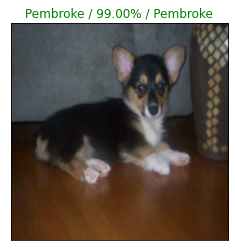

In [ ]:
plot_pred(preds,unbatched_label,unbatched_image, 4)

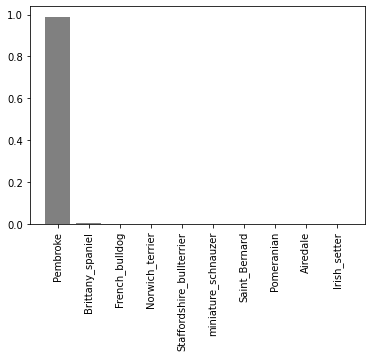

In [ ]:
plot_pred_conf(preds, unbatched_label, 4)

## Saving and reloading a trained model

In [ ]:
# Create a function to save model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix(string)
  """

  # Create model directory pathname. with current time
  modeldir = os.path.join("Models",
                          datetime.datetime.now().strftime("%Y:%m:%d-%H:%M%s"))
  model_path = modeldir + "-" + suffix + ".h5"
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

# Create a function to load model
def load_model(model_path):
  """
  Loads a saved model from a specified path
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer" : hub.KerasLayer})
  return model


In [ ]:
# Save a model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: /Models/2022:06:25-08:131656144811-1000-images-mobilenetv2-Adam.h5...


'/Models/2022:06:25-08:131656144811-1000-images-mobilenetv2-Adam.h5'

In [ ]:
# Load a model trained on 1000 images
loaded_1000_image_model = load_model("Models/2022:06:25-08:071656144422-1000-images-mobilenetv2-Adam.h5")

Loading saved model from: Models/2022:06:25-08:071656144422-1000-images-mobilenetv2-Adam.h5


In [ ]:
loaded_1000_image_model.evaluate(val_batch)

7/7 [==============================] - 1s 79ms/step - loss: 0.0933 - accuracy: 0.9600


[0.09333185106515884, 0.9599999785423279]

## NOW, lets test with the full data

In [ ]:
print(len(x), len(y))
full_data = create_data_batches(x,y)
full_data

20579 20579
Creating training data batches... BATCH SIZE=32


<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
# Create full model
full_model = create_model()
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set since we're training on all the data, so we can't monitor validation accuracy (So we need to use early stopping)
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=3) # Stops when accuracy does not improve for 3 epochs

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [ ]:
# Fit the model to full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping]
               )


Epoch 1/100
644/644 [==============================] - 71s 97ms/step - loss: 0.9665 - accuracy: 0.7416
Epoch 2/100
644/644 [==============================] - 64s 99ms/step - loss: 0.3890 - accuracy: 0.8781
Epoch 3/100
644/644 [==============================] - 63s 98ms/step - loss: 0.2657 - accuracy: 0.9141
Epoch 4/100
644/644 [==============================] - 64s 99ms/step - loss: 0.1928 - accuracy: 0.93960s - loss: 0.1930 - ac
Epoch 5/100
644/644 [==============================] - 63s 98ms/step - loss: 0.1443 - accuracy: 0.9566
Epoch 6/100
644/644 [==============================] - 64s 99ms/step - loss: 0.1133 - accuracy: 0.9676
Epoch 7/100
644/644 [==============================] - 64s 99ms/step - loss: 0.0924 - accuracy: 0.9746
Epoch 8/100
644/644 [==============================] - 61s 95ms/step - loss: 0.0803 - accuracy: 0.9776
Epoch 9/100
644/644 [==============================] - 61s 94ms/step - loss: 0.0684 - accuracy: 0.9822
Epoch 10/100
644/644 [=============================

'/Models/2022:06:26-10:191656238794-full-image-set-mobilenetv2-Adam.h5'

In [ ]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: Models/2022:06:26-10:201656238844-full-image-set-mobilenetv2-Adam.h5...


'Models/2022:06:26-10:201656238844-full-image-set-mobilenetv2-Adam.h5'

## Testing the loaded full model on some custom images

In [ ]:
loaded_full_model = load_model("Models/2022:06:26-10:201656238844-full-image-set-mobilenetv2-Adam.h5")

Loading saved model from: Models/2022:06:26-10:201656238844-full-image-set-mobilenetv2-Adam.h5


In [ ]:
custom_images = [ "custom-images/" + fname for fname in os.listdir("custom-images")]
custom_images

['custom-images/S__18554885.jpg',
 'custom-images/image.jpeg',
 'custom-images/WhatsApp Image 2022-06-16 at 9.22.39 PM.jpeg',
 'custom-images/WhatsApp Image 2022-06-16 at 8.28.28 PM.jpeg',
 'custom-images/Shiba-Inu-standing-in-profile-outdoors.jpeg',
 'custom-images/S__18554887.jpg',
 'custom-images/pompom.jpeg']

In [ ]:
custom_batch = create_data_batches(custom_images, test_data=True)
custom_batch

Creating test data batches... BATCH SIZE=32


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [ ]:
custom_predictions = loaded_full_model.predict(custom_batch)
custom_predictions

array([[2.76480109e-15, 2.47692616e-10, 2.72589417e-16, 7.93597219e-12,
        9.93571595e-15, 5.61919800e-09, 3.97722341e-11, 5.33903596e-13,
        5.74451551e-16, 4.73538689e-13, 1.71503234e-05, 1.68064895e-10,
        1.45538248e-10, 2.19640817e-09, 5.54721411e-15, 2.41164536e-11,
        6.23021585e-16, 6.09367057e-10, 2.00458157e-08, 7.98062625e-13,
        6.67026884e-15, 1.97695506e-11, 4.87497008e-17, 1.24748657e-16,
        1.17158800e-12, 2.50149450e-11, 1.50661128e-16, 3.35783103e-11,
        3.55339639e-14, 1.21765265e-06, 1.33540070e-15, 3.58337820e-06,
        2.51790962e-14, 1.96674088e-14, 3.47679212e-11, 4.48233888e-17,
        4.18551371e-09, 4.56057220e-10, 7.92345800e-10, 3.42286425e-03,
        5.23668836e-13, 3.48009642e-11, 1.42725867e-08, 1.56533866e-11,
        7.61414654e-14, 2.32337996e-10, 9.43608021e-18, 7.74463935e-13,
        4.05087162e-12, 1.21749583e-10, 3.19580730e-22, 4.48080106e-09,
        2.52630880e-14, 1.98807854e-12, 2.99287015e-18, 4.635377

## Let's make a function to do 

In [ ]:
# COMPLETE DOG BREED PREDICTION FUNCTION
def dog_breed_predict(filename_list: list, model):
  # Turn images into batch datasets
  file_batch = create_data_batches(filename_list, test_data=True)
  # Make predictions on the data
  prediction = model.predict(file_batch)
  # Get custom image prediction labels
  custom_pred_labels = [get_pred_label(i) for i in prediction]
  # Unbatch batched datasets
  custom_images = []
  for image in file_batch.unbatch().as_numpy_iterator():
    custom_images.append(image)
  # Plot results
  no_rows = len(filename_list)//3 + (0 if (len(filename_list)%3 == 0) else 1)
  no_cols = 3
  if len(filename_list) < 3:
    no_cols = len(filename_list) * 3

  plt.figure(figsize=(3*no_cols,3*no_rows))
  for i, image in enumerate(custom_images):
    # Confidence percentage
    confidence_perc = np.max(prediction[i])*100

    # Coloring based on confidence
    if confidence_perc >= 85:
        color = "green"
    elif confidence_perc >= 70:
        color = "yellow"
    elif confidence_perc >= 50:
        color = "orange"
    else:
        color = "red"
       
    plt.subplot(no_rows,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title("{} / {:2.2f}%".format(custom_pred_labels[i], confidence_perc), color=color)
    plt.imshow(image)

Creating test data batches... BATCH SIZE=32


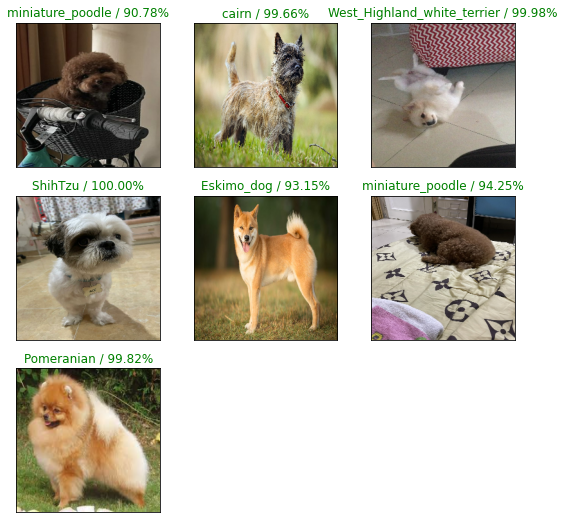

In [ ]:
dog_breed_predict(custom_images, loaded_full_model)

## Data Augmentation for further improvement on model (Enrichment of training data)

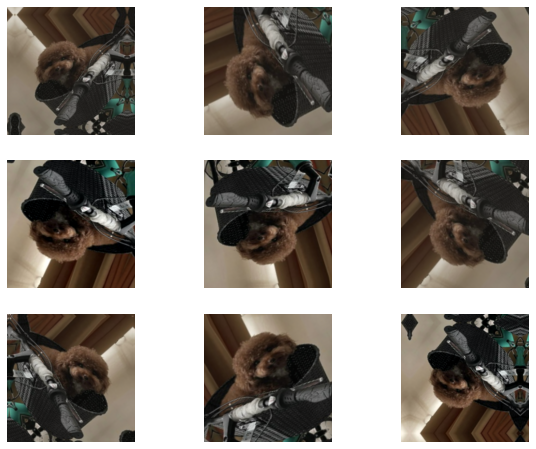

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomCrop(height=IMG_SIZE, width=IMG_SIZE),
  tf.keras.layers.RandomContrast(0.25)
])

# Show example of augmentations
image = process_image(custom_images[0])
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

plt.figure(figsize=(10, 8))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [ ]:
x_augmented = []
y_augmented = []
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

for idx in range(len(x)):
    image = process_image(x[idx])
    x_augmented.append(image)
    y_augmented.append(y[idx])
    for i in range(4):
      image = data_augmentation(image)
      x_augmented.append(image)
      y_augmented.append(y[idx])
    print(f"{idx} / {len(x)} DONE")


In [ ]:
len(x_augmented), len(y_augmented), len(x), len(y) # Supposed to be 5x the size (created 5 variants of augmentation for each)